In [1]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle


warnings.filterwarnings('ignore')

DATA = 'data'
SEED = 123

## 데이터 로드

In [2]:
train = pd.read_csv(os.path.join(DATA, 'train.csv'))
test = pd.read_csv(os.path.join(DATA, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA, 'sample_submission.csv'))

In [3]:
from pycaret.regression import *        # 회귀

In [4]:
train.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [5]:
categorical_features = ['Species', 'Island', 'Clutch Completion', 'Sex']
numeric_features = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
ignore_features = ['id']

In [197]:
def run_compare_models(seed):
    clf = setup(data=train, 
                target='Body Mass (g)', 
                session_id=seed, 
                normalize=True,                            # 정규화 적용
                normalize_method='zscore',                 # 정규화 방식 지정
                imputation_type='iterative',               # 결측치를 lightgbm으로 예측하여 채움
                iterative_imputation_iters=10,
                ignore_features=ignore_features,
                categorical_features=categorical_features, 
                numeric_features=numeric_features,
#                 polynomial_features=True,
#                 polynomial_degree=3,
#                 transform_target=True, 
#                 transformation=True,
#                 remove_outliers = True,
                use_gpu=True,
                train_size=0.8,
                silent=True, 
                verbose=False,
                ) 

    best_models = compare_models(n_select=5, fold=5, round=2, sort='RMSE')
    blended_models = blend_models(best_models, fold=5, optimize='RMSE', verbose=False)
    score_grid = pull()
    score = score_grid.loc['Mean']['RMSE']

    model_list = [m for m, _ in blended_models.estimators]
    return model_list, score

In [198]:
def single_model_pipeline(model_name):
    m = create_model(model_name)
    m_tune = tune_model(m, n_iter=100, optimize='RMSE', verbose=False)
    m_final = finalize_model(m_tune)
    m_pred = predict_model(data=test, estimator=m_final)
    score_grid = pull()
    score = score_grid.loc['Mean']['RMSE']
    return model_name, score, m_pred['Label'].values

In [199]:
# compare_model_scores = dict()
# single_model_scores = dict()
with open('compare_model_scores.pickle', 'rb') as f:
    compare_model_scores = pickle.load(f)
    
with open('single_model_scores.pickle', 'rb') as f:
    single_model_scores = pickle.load(f)

In [35]:
# single_model_scores

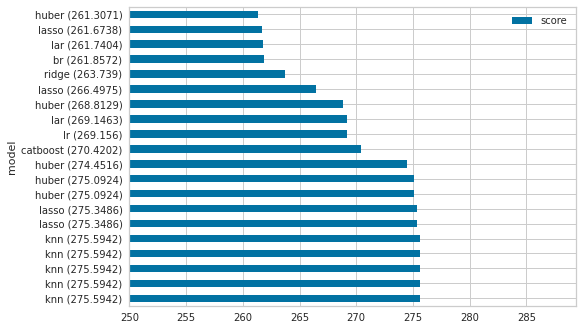

In [38]:
model_score_df = pd.DataFrame()
for model_name, score in single_model_scores.items():
    for s, pred in score:
        model_score_df = model_score_df.append({'model': f'{model_name} ({s})', 'score': s, 'pred': pred}, ignore_index=True)
        
model_score_df.sort_values('score', ascending=False).tail(20).plot(kind='barh', x='model')
plt.xlim(250,)
plt.show()

In [ ]:
max_iterations = 1000

for i in range(max_iterations):
    seed = np.random.randint(2022)

    model_list, score = run_compare_models(seed)
    print(f'seed: {seed}, blending_score: {score}, moddel_list: {model_list}')
    # Seed 값에 따른 모델 score 저장
    compare_model_scores[seed] = score
    
    # compare_model_scores 저장
    with open('compare_model_scores.pickle', 'wb') as f:
        pickle.dump(compare_model_scores, f, pickle.HIGHEST_PROTOCOL)

    for model in model_list:
        try:
            model_name, score, preds = single_model_pipeline(model)

            m = single_model_scores.get(model_name)
            if m == None:
                single_model_scores[model_name] = []

            single_model_scores[model_name].append((score, preds))

            # single_model_scores 저장
            with open('single_model_scores.pickle', 'wb') as f:
                pickle.dump(single_model_scores, f, pickle.HIGHEST_PROTOCOL)
        except:
            print('Exception occured..')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,181.0250,42421.6688,205.9652,0.9426,0.0532,0.0473
1,348.2222,162301.3750,402.8664,0.6689,0.0880,0.0761
2,476.8056,260742.9236,510.6299,0.1543,0.1262,0.1101
3,347.8056,188143.8125,433.7555,0.7576,0.0892,0.0698
4,371.4167,180090.3125,424.3705,0.6559,0.0972,0.0847
5,336.1111,179413.9167,423.5728,0.7760,0.1183,0.0908
6,155.6111,32345.6111,179.8489,0.9000,0.0399,0.0361
7,220.2222,97083.8333,311.5828,0.8388,0.0787,0.0563
8,137.0556,28702.5556,169.4183,0.9430,0.0412,0.0333
9,288.0833,124657.4097,353.0686,0.7658,0.0979,0.0777


INFO:logs:create_model_container: 30
INFO:logs:master_model_container: 30
INFO:logs:display_container: 12
INFO:logs:ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=1246, verbose=0, warm_start=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing tune_model()
INFO:logs:tune_model(kwargs={}, display=None, tuner_verbose=True, verbose=False, return_tuner=False, groups=None, fit_kwargs=None, choose_better=False, early_stopping_max_iters=10, early_stopping=False, search_algorithm=None, search_library=scikit-learn, custom_scorer=None, optimi

Exception occured..


INFO:logs:Creating preprocessing pipeline
INFO:logs:Preprocessing pipeline created successfully
ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
INFO:logs:Creating global containers
INFO:logs:Internal pipeline: Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False)
INFO:logs:Iterative Imputation: 1 cycle | Sex
INFO:logs:Iterative Imputation: 1 cycle | Delta 15 N (o/oo)
INFO:logs:Iterative Imputation: 1 cycle | Delta 13 C (o/oo)
INFO:logs:Iterative Imputation: 2 cycle | Sex
INFO:logs:Iterative Imputation: 2 cycle | Delta 15 N (o/oo)
INFO:logs:Iterative Imputation: 2 cycle | Delta 13 C (o/oo)
INFO:logs:Iterative Imputation: 3 cycle | Sex
INFO:logs:Iterative Imputation: 3 cycle | Delta 15 N (o/oo)
INFO:logs:Iterative Imputation: 3 cycle | Delta 13 C (o/oo)
INFO:logs:Iterative Imputation: 4 cycle | Sex
INFO:logs:Iterative Imputation: 4 cycle | Delta 15 N (o/oo)
INFO:logs:Iterative Imputation: 4 cycle | Delta 13 C (o/oo)
I

In [19]:
sorted(compare_model_scores.items(), key=lambda x: x[1])

[(471, 259.1711),
 (1992, 274.0363),
 (997, 281.992),
 (1815, 284.8618),
 (1931, 287.0621),
 (1847, 287.7209),
 (1660, 288.1938),
 (1240, 288.9818),
 (54, 291.0941),
 (1362, 291.3861),
 (791, 292.4723),
 (1625, 292.7763),
 (1409, 294.1931),
 (1910, 294.9531),
 (314, 296.4813),
 (696, 296.6054),
 (235, 297.4686),
 (1303, 298.8769),
 (1254, 299.0085),
 (412, 300.747),
 (1473, 301.1073),
 (1824, 303.152),
 (1697, 304.463),
 (1695, 304.8565),
 (1365, 306.5657),
 (1040, 307.8302),
 (1608, 307.9227),
 (647, 307.9901),
 (1932, 308.0236),
 (1135, 308.2306),
 (941, 308.4391),
 (1461, 308.4569),
 (393, 308.7431),
 (1432, 309.2683),
 (1517, 309.3929),
 (1157, 309.8577),
 (684, 311.4116),
 (285, 314.2768),
 (1652, 314.3508),
 (603, 314.3614),
 (1737, 314.3901),
 (363, 314.5974),
 (1714, 314.7704),
 (61, 314.8819),
 (1207, 315.6004),
 (358, 315.836),
 (1246, 317.0755),
 (1030, 317.3262),
 (924, 317.574),
 (1206, 317.9699),
 (1571, 317.9745),
 (2005, 319.0406),
 (348, 319.9528),
 (1138, 320.588),
 (

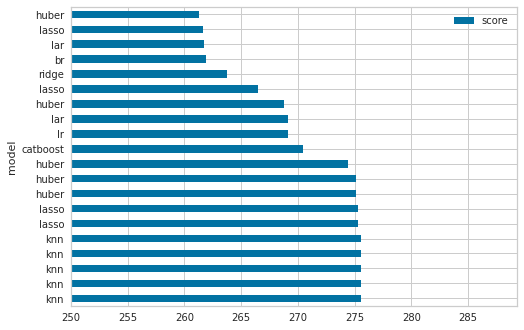

In [179]:
model_score_df = pd.DataFrame()
for model_name, score in single_model_scores.items():
    for s, pred in score:
        model_score_df = model_score_df.append({'model': model_name, 'score': s, 'pred': pred}, ignore_index=True)
        
model_score_df.sort_values('score', ascending=False).tail(20).plot(kind='barh', x='model')
plt.xlim(250,)
plt.show()

In [39]:
model_score_df.g

,model,pred,score
0,huber (312.3958),"[4366.462211820927, 5645.242621755903, 3592.32...",312.3958
1,huber (289.9458),"[4372.288996548956, 5655.18048337177, 3572.522...",289.9458
2,huber (304.2948),"[4378.2464859577685, 5651.757687209758, 3581.4...",304.2948
3,huber (278.7312),"[4385.228469902849, 5642.9474620902, 3581.0190...",278.7312
4,huber (312.4931),"[4378.868330104951, 5672.36972772887, 3624.273...",312.4931
...,...,...,...
2638,ada (300.0474),"[4455.124999249332, 5559.144387170282, 3514.00...",300.0474
2639,ada (322.9359),"[4423.097864331079, 5514.612435148041, 3519.56...",322.9359
2640,ada (300.0474),"[4455.124999249332, 5559.144387170282, 3514.00...",300.0474
2641,ada (322.9359),"[4423.097864331079, 5514.612435148041, 3519.56...",322.9359


## top 5 ensemble

In [21]:
top_5 = model_score_df.sort_values('score', ascending=False).tail(4)
top_5

,model,pred,score
1256,br,"[4326.239819884746, 5627.342350606244, 3599.87...",261.8572
445,lar,"[4339.377293071334, 5650.32121282914, 3604.058...",261.7404
971,lasso,"[4307.0674, 5508.832, 3571.0703, 3456.1587, 33...",261.6738
166,huber,"[4353.780822224873, 5632.633613971631, 3583.81...",261.3071


In [22]:
final_pred = top_5['pred'].values.mean()
final_pred[:10]

array([4331.6163295 , 5604.78230216, 3589.70614322, 3364.64464449,
       3492.73580141, 4191.81224793, 4606.43757277, 5299.04622607,
       4784.10051906, 4054.51756503])

In [23]:
sample_submission['Body Mass (g)'] = final_pred
sample_submission.to_csv('top-5-ensemble-01.csv', index=False)

## under 스코어 ensemble

In [190]:
target_score = 300
bst_models = model_score_df.loc[model_score_df['score'] < target_score]
mean_score = bst_models.groupby('model')['score'].mean()
mean_score

model
br          288.470110
catboost    293.547132
huber       292.128251
knn         287.448696
lar         294.230621
lasso       290.956073
lr          294.717969
par         289.145700
ridge       288.589349
Name: score, dtype: float64

In [191]:
mean_score = np.exp(mean_score)
weights = (mean_score.sum() - mean_score) / mean_score.sum()
weights = weights / weights.sum()
weights

model
br          0.124881
catboost    0.105917
huber       0.120382
knn         0.124957
lar         0.087200
lasso       0.123570
lr          0.063462
par         0.124766
ridge       0.124866
Name: score, dtype: float64

In [192]:
mean_pred = bst_models.groupby('model')['pred'].apply(lambda x: x.mean())
mean_pred

model
br          [4316.465460436625, 5659.856703140195, 3602.27...
catboost    [4133.995627198394, 5637.750999174499, 3549.55...
huber       [4341.315500522014, 5702.1276019549505, 3554.9...
knn         [4178.108462890081, 5534.99786727329, 3572.099...
lar         [4339.710016864689, 5649.974956893723, 3601.26...
lasso       [4311.375, 5499.4316, 3574.9727, 3458.6667, 33...
lr          [4320.8467, 5684.5557, 3600.5579, 3334.44, 351...
par         [4386.572140374795, 5645.336711072523, 3634.70...
ridge       [4309.7627, 5642.2554, 3616.8853, 3396.761, 35...
Name: pred, dtype: object

In [193]:
(mean_pred * weights)

model
br          [539.0443006160683, 706.8082731334453, 449.855...
catboost    [437.8584266185377, 597.1309611274459, 375.956...
huber       [522.6166312337946, 686.4340354532177, 427.947...
knn         [522.0844476037204, 691.6374550085895, 446.359...
lar         [378.42212449410204, 492.67704943817677, 314.0...
lasso       [532.75604, 679.564, 441.7589, 427.387, 415.44...
lr          [274.2081, 360.75134, 228.49739, 211.6091, 222...
par         [547.2952387208974, 704.3463105299111, 453.487...
ridge       [538.1423, 704.52515, 451.62555, 424.13953, 44...
dtype: object

In [194]:
weighted_blending_pred = (mean_pred * weights).sum()
weighted_blending_pred[:10]

array([4292.42758408, 5623.87459983, 3589.51834109, 3393.6666168 ,
       3502.29583519, 4183.01087905, 4612.02718653, 5235.18920065,
       4755.48956274, 4049.68731755])

In [195]:
output_pred = pd.read_csv('ouput11.csv')['Body Mass (g)']
output_pred.values[:10]

array([4292.07638639, 5614.21843795, 3565.08160152, 3406.07247859,
       3468.40183948, 4194.81546278, 4600.0359176 , 5269.03865666,
       4725.62862096, 4119.70434727])

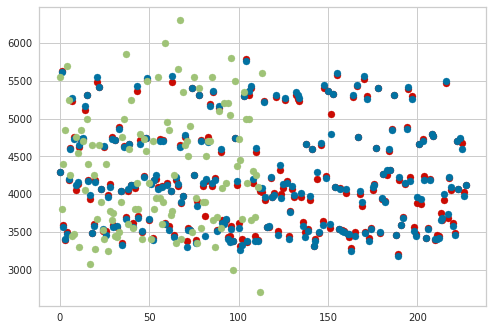

In [187]:
plt.scatter(x=np.arange(len(weighted_blending_pred)), y=weighted_blending_pred, color='r')
plt.scatter(x=np.arange(len(output_pred)), y=output_pred, color='b')
plt.scatter(x=np.arange(len(train['Body Mass (g)'])), y=train['Body Mass (g)'], color='g')

In [160]:
# final_pred = output_pred *0.7 + weighted_blending_pred * 0.3
# final_pred

0      4292.861996
1      5612.399992
2      3566.954073
3      3408.609117
4      3478.475037
          ...     
223    4077.262719
224    4745.286713
225    4620.119238
226    3990.002254
227    4109.811724
Name: Body Mass (g), Length: 228, dtype: float64

In [196]:
sample_submission['Body Mass (g)'] = weighted_blending_pred
sample_submission.to_csv('output15.csv', index=False)

## compare models

In [24]:
clf = setup(data=train, 
            target='Body Mass (g)', 
            session_id=1992, 
            normalize=True,                            # 정규화 적용
            normalize_method='zscore',                 # 정규화 방식 지정
            imputation_type='iterative',               # 결측치를 lightgbm으로 예측하여 채움
            iterative_imputation_iters=20,
            ignore_features=ignore_features,
            categorical_features=categorical_features, 
            numeric_features=numeric_features,
            remove_outliers = True,
            use_gpu=True,
            train_size=0.8,
            silent=True, 
            verbose=False,
            ) 

best_models = compare_models(n_select=5, fold=5, round=2, sort='RMSE')
blended_models = blend_models(best_models, fold=5, optimize='RMSE', verbose=False)
finalized_models = finalize_model(blended_models)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,211.84,75801.36,273.63,0.86,0.06,0.05,0.03
llar,Lasso Least Angle Regression,210.94,76853.66,274.31,0.86,0.06,0.05,0.01
ridge,Ridge Regression,210.84,77610.04,276.38,0.86,0.06,0.05,0.01
br,Bayesian Ridge,211.62,77796.46,276.78,0.86,0.06,0.05,0.01
lasso,Lasso Regression,212.69,78018.17,277.45,0.86,0.06,0.05,0.01
lr,Linear Regression,215.23,78787.19,278.88,0.86,0.06,0.05,0.01
par,Passive Aggressive Regressor,215.62,79108.35,279.68,0.86,0.07,0.05,0.01
lightgbm,Light Gradient Boosting Machine,228.98,85025.09,287.82,0.85,0.07,0.05,2.05
et,Extra Trees Regressor,244.46,87409.60,293.42,0.84,0.07,0.06,0.77
catboost,CatBoost Regressor,250.26,91584.04,299.76,0.84,0.07,0.06,1.01


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 2
INFO:logs:[HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False), LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, jitter=None, max_iter=500, normalize=True,
          positive=False, precompute='auto', random_state=1992, verbose=False), Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=1992, solver='auto', tol=0.001), BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False), Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1

INFO:logs:blend_models() succesfully completed......................................
INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(display=None, model_only=True, groups=None, fit_kwargs=None, estimator=VotingRegressor(estimators=[('huber',
                             HuberRegressor(alpha=0.0001, epsilon=1.35,
                                            fit_intercept=True, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('lar',
                             LassoLars(alpha=1.0, copy_X=True,
                                       eps=2.220446049250313e-16,
                                       fit_intercept=True, fit_path=True,
                                       jitter=None, max_iter=500,
                                       normalize=True, positive=False,
                                       precompute='auto', random_state=1992,
                                       verbose=False)),
       

INFO:logs:finalize_model() succesfully completed......................................


In [25]:
blended_pred = predict_model(data=test, estimator=finalized_models)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(display=None, ml_usecase=MLUsecase.REGRESSION, verbose=True, round=4, raw_score=False, encoded_labels=True, probability_threshold=None, estimator=VotingRegressor(estimators=[('huber',
                             HuberRegressor(alpha=0.0001, epsilon=1.35,
                                            fit_intercept=True, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('lar',
                             LassoLars(alpha=1.0, copy_X=True,
                                       eps=2.220446049250313e-16,
                                       fit_intercept=True, fit_path=True,
                                       jitter=None, max_iter=500,
                                       normalize=True, positive=False,
                                       precompute='auto', random_state=1992,
                                       verbose=False)),
                   

In [28]:
output_pred = pd.read_csv('ouput11.csv')['Body Mass (g)']
output_pred.values[:10]

array([4292.07638639, 5614.21843795, 3565.08160152, 3406.07247859,
       3468.40183948, 4194.81546278, 4600.0359176 , 5269.03865666,
       4725.62862096, 4119.70434727])

In [29]:
ensemble_pred = 0.8 * output_pred + blended_pred['Label'].values * 0.2
ensemble_pred

0      4302.949087
1      5616.521255
2      3571.665804
3      3396.474760
4      3472.062186
          ...     
223    4082.478503
224    4748.115038
225    4628.161915
226    4001.813895
227    4116.408043
Name: Body Mass (g), Length: 228, dtype: float64

In [30]:
sample_submission['Body Mass (g)'] = ensemble_pred
sample_submission.to_csv('ensemble-blending-01.csv', index=False)

## 제출

In [ ]:
sample_submission['Body Mass (g)'] = ensemble_pred
sample_submission.to_csv('ouput12.csv', index=False)

In [ ]:
sample_submission